In [26]:
library(DESeq2)
library(WGCNA)
library(GENIE3)
library(reshape2)
library(stringr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggpubr)
library(gridExtra)
library(grid)

# directory of the project
work_path <- "./"

## Codes for Brassica rapa HD analysis

### 1. WGCNA analysis of individual stress-responsive gene groups
1. Identify WGCNA modules (Supplemental Figure S8)
1. Plot gene expression profiles (Figures 4A-C, 7C and Supplemental Figure S9)
1. GO enrichment analysis of each module (Figure 4D, Supplemental Figure S12)

### 2. Reconstruct the Gene regulatory network (GRN), keyGRN and TF-TF network
1. GRN and TF-TF GRN (Supplemental Figure S13)
1. keyGRN

### 3. Network analysis (_______ links to Rachelle's github _______)
1. Network dispersion analysis for GRN, keyGRN, and TF-TF network (Figure 5 and Supplemental Figure S14)
1. Top-level TF analysis (Figure 6 and Supplemental Figure S15)

### 4. Modified GO enrichment analysis of BLAST-mappable and -unmappable genes to A. thaliana orthologues (_______ links to Rachelle's github _______)
1. Supplemental Figures S5: Gene counts of GO terms mapped via orthologous families with different normalisation methods against counts of GO terms mapped via A. thaliana orthologue identified by BLAST.
1. Supplemental Figure S6: GO enrichment analysis of all B. rapa genes with different mapping methods and universes.
1. Supplemental Figure S7: GO enrichment analysis of treatment DEGs (HD-responsible genes) with different mapping methods and universes.

### 5. Identify ancestral GO terms (_______ links to Rachelle's github _______)
1. Figure 3B and 4D, Supplemental Figure S3 and S11: GO hierarchy containing GO terms of interest

### 6. Detect putative cis-regulatory elements (pCRE)
1. Supplemental Figures S16 and S17: pCREs enriched in the target genes of a TF


## 1. WGCNA analysis of individual stress-responsive gene groups

### 1.1 Identify WGCNA modules (Supplemental Figure S8)

In [27]:
# param for each stress-responsive group (E_CR, GxE_control, GxE_HD, GxE_cHD)
#!!!!! users just change group name here and then run the following codes for WGCNA analysis !!!!!

# groupname <- "ECR"
# groupname_full <- "E_CR"
# rsquareCF = 0.7  # cutoff of r2 (actual network ~ scale-free network)

# groupname <- "C"
# groupname_full <- "GxE_control"
# rsquareCF = 0.85

# groupname <- "HD"
# groupname_full <- "GxE_HD"
# rsquareCF = 0.85

# groupname <- "CHD"
# groupname_full <- "GxE_cHD"
# rsquareCF = 0.85

groupname <- "CHD"
groupname_full <- "GxE_cHD"
rsquareCF = 0.85


pickSoftThreshold: will use block size 1699.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1699 of 1699
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.00557  1.850          0.533   854.0    858.00  903.0
2      2  0.23600  4.080          0.864   528.0    521.00  636.0
3      3  0.22800  1.790          0.865   365.0    357.00  511.0
4      4  0.17800  0.931          0.875   269.0    258.00  430.0
5      5  0.08490  0.434          0.844   207.0    195.00  373.0
6      6  0.01160  0.120          0.790   164.0    151.00  328.0
7      7  0.04560 -0.188          0.773   133.0    118.00  294.0
8      8  0.20900 -0.367          0.774   110.0     93.80  265.0
9      9  0.46200 -0.540          0.802    92.3     75.30  242.0
10    10  0.64600 -0.666          0.846    78.5     60.90  223.0
11    12  0.84000 -0.847          0.898    58.6     41.70  193.0
12    14  0.92700 -1.010          0.933    45.2     29.10  170.0


pdf 
  2

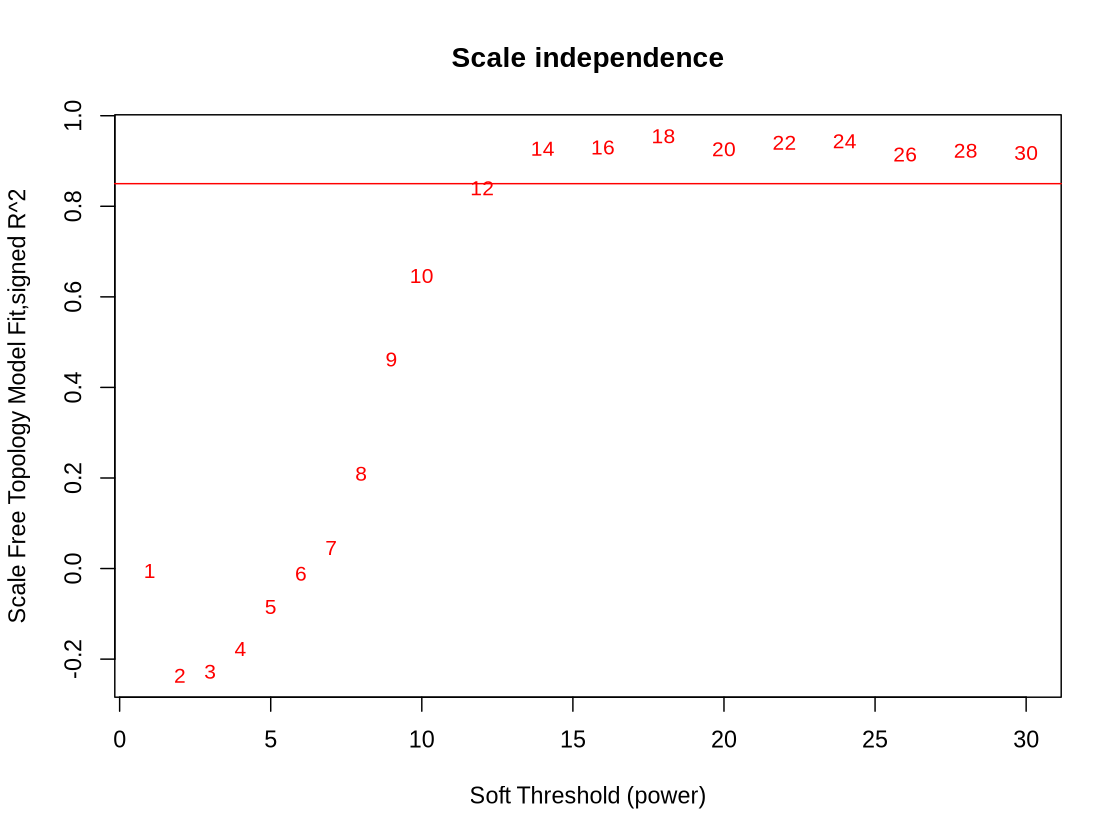

In [28]:
## 1. load and transform data for wgcna
infile_wgcna <- paste0(work_path, "input/genes_vst.", groupname, ".txt")
dataExpr0 <- read.table(infile_wgcna, sep='\t', header=TRUE) %>%
    as.data.frame() %>% filter()
dataExpr <- as.data.frame(t(dataExpr0))

gene.names <- colnames(dataExpr)
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)

## 2. sample clustering
options(repr.plot.width=10, repr.plot.height=6, repr.plot.res = 140)
sampleTree = hclust(dist(dataExpr), method = "average")
#plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

## 3. determine soft threshold (power)
powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, RsquaredCut = rsquareCF,
                        networkType=type, verbose=5)

# R2 ~ power
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 140)
cex1 = 0.9
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
abline(h=rsquareCF,col="red")

# choose power
power = sft$powerEstimate
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}
print(paste('calculating power = ' , power) )

## 4. generating adjacency and TOM similarity matrices based on the selected softpower
softPower = power;

# calclute the adjacency matrix
adj= adjacency(dataExpr,type = type, power = softPower);

# turn adjacency matrix into topological overlap to minimize the effects of noise and spurious associations
TOM=TOMsimilarityFromExpr(dataExpr,networkType = type, TOMType = type, power = softPower);
colnames(TOM) =rownames(TOM) = gene.names
dissTOM=1-TOM

library(flashClust)
geneTree = flashClust(as.dist(dissTOM),method="average")

# set the minimum module size
minModuleSize = 40

## 5. module identification using dynamic tree cut
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM, method="hybrid", 
                            deepSplit = 2, pamRespectsDendro = FALSE, 
                            minClusterSize = minModuleSize);
dynamicColors = labels2colors(dynamicMods)

# quantify module similarity by eigengene correlation. 
# eigengenes: Module representatives
# calculate eigengenes
MEList = moduleEigengenes(dataExpr, colors = dynamicColors)
MEs = MEList$eigengenes

# calculate dissimilarity of module eigengenes
MEDiss = 1-cor(MEs);
# cluster module eigengenes
METree = hclust(as.dist(MEDiss), method = "average");
MEDissThres = 0.25 # 0.25 default

# call an automatic merging function
merge = mergeCloseModules(dataExpr, dynamicColors, cutHeight = MEDissThres, verbose = 3)
# the merged module colors
mergedColors = merge$colors;
# eigengenes of the new merged modules:
mergedMEs = merge$newMEs;

## 6. hierarchical cluster tree showing co-expression modules identified using WGCNA for each group
# save to file
outfile_geneDendro <- paste0(work_path, "output_WGCNA/", groupname, ".geneDendro_merged.pdf", sep="")
pdf(outfile_geneDendro, width = 14, height = 7)
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
  c("Dynamic Tree Cut", "Merged dynamic"),
  autoColorHeight = FALSE, colorHeight = 0.16,
  dendroLabels = FALSE, hang = 0.03,
  addGuide = TRUE, guideHang = 0.05)
dev.off()

## 7. KME (module eigengene connectivity) used for choosing key genes
## module eigengene (ME) as the first principal component of genes in a module, represents the overall expression pattern of the module
modules <- names(table(mergedColors))
datKME_all <- data.frame()
for (m in modules)
{
    # module eigengene for 48 samples
    ME = as.data.frame(mergedMEs[ , paste("ME", m, sep="")])  # MEblack
    colnames(ME) <- m
    # counts of genesin this module
    datModExpr <- dataExpr[ , mergedColors==m]
    msize <- length(colnames(datModExpr))
    # module membership (kME) values: the core degree of a gene in a module
    datKME = signedKME(datModExpr, ME)

    datKME <- cbind(datKME, m, msize) %>% setNames(c('kME', 'module', 'modulesize')) %>%
        tibble::rownames_to_column('Gene')

    # combine
    datKME_all <- datKME_all %>% rbind(datKME)
    
}

# save to file
file_datKME <- paste0(work_path, "output_WGCNA/", groupname, ".genes_kME.txt")
datKME_all %>% write.table(file_datKME, quote=FALSE, row.names=FALSE, sep="\t")


### 1.2 Plot gene expression profiles (Figures 4A-C, 7C and Supplemental Figure S9)


In [36]:
## 1. prepare data for plotting gene expression profiles
# read log2 transformed count data 
dds_counts_long_log2<- readRDS(paste0( work_path, "input/genes_log2counts_long.rds"))
#head(dds_counts_long_log2)
dds_counts_long_log2 <- dds_counts_long_log2 %>% mutate(line_treatment = line_treatment %>% str_replace('-H$', '-HD'))

# read gene~kME~module information
datKME_all <- read.table(paste0(work_path, "output_WGCNA/", groupname, ".genes_kME.txt"), header=TRUE, sep="\t") %>%
    as.data.frame() %>% mutate(module = paste0("ME", module))
#head(datKME_all,2)

# combine gene count data and module data together
dds_counts_long_log2_nodes <- dds_counts_long_log2 %>% 
    left_join( datKME_all, by = c('Gene') ) %>% tidyr::drop_na(module) %>% 
    filter(module != 'MEgrey')

dds_counts_long_log2_nodes$line_treatment <- factor(dds_counts_long_log2_nodes$line_treatment, 
                                                    levels=c("B10-C", "B10-HD", "B11-C", "B11-HD"), 
                                                    ordered=TRUE)


In [ ]:
## 2. general profile of each module used in Figures 4A-C and Supplemental Figure S9

# order modules by size descreasingly
dds_counts_long_log2_nodes_plot <- dds_counts_long_log2_nodes %>%
    mutate(module4plot = paste0(module, ' (', modulesize, ')'))

modules <- datKME_all %>% distinct(module, modulesize)
modules_ordered <- modules[ order(modules$modulesize, decreasing=TRUE), ] 
modules_size_ordered <- paste0(modules_ordered$module, ' (', modules_ordered$modulesize, ')')
dds_counts_long_log2_nodes_plot$module4plot <- factor(dds_counts_long_log2_nodes_plot$module4plot, 
                        levels = modules_size_ordered,
                        ordered = TRUE)

# plot expression profile of each module
plot_module <-  ggplot(dds_counts_long_log2_nodes_plot, 
                         aes(x=time,y=log2_count, colour=line_treatment, linetype = line_treatment, group=line_treatment)) +
    stat_summary(fun.data = "mean_cl_boot", geom = "smooth") +  # mean_cl_boot: Mean Standard error from bootstrap
    stat_summary(fun.data = "mean_cl_boot", geom = "ribbon", alpha = 0.1, fill = 'grey', linetype = 0) +

    scale_color_manual(values = c('B10-C' = '#f19da9', 'B10-HD' = '#f19da9', 'B11-C' = '#8bcae4', 'B11-HD' = '#8bcae4')) +
    scale_linetype_manual(values = c('B10-C' = "dotted", 'B10-HD' = "solid", 'B11-C' = "dotted", 'B11-HD' = "solid"  )) +

    ggh4x::facet_wrap2(vars(module4plot),  ncol = 4 , scales = "free_y",  #independent = "y" ,
                       labeller = labeller( multi_line = TRUE, sep = "_"))  +
    scale_x_continuous(breaks = c(0, 3, 12, 24)) +
    theme_bw() +
    theme(
        legend.position = "bottom",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()
    )

# save this plot
Nmodules = nrow(modules)
N_cols <- 4
N_rows <- ceiling(Nmodules/N_cols)
if(Nmodules < 4)
{
   N_cols <- Nmodules
}
    
pdf(paste0(work_path, "output_WGCNA/", groupname, ".expprofile.pdf"), width = 2*N_cols, height = 2*N_rows)
grid.draw(plot_module)
dev.off()

In [38]:
## 3. expression profile of individual genes used in Figure 7C

plot_counts <- function (counts_table, ncol =5) {
    plot <- counts_table %>% ggplot(  aes(x = time, y = log2_count, colour  = line_treatment, linetype = line_treatment, group = line_treatment)) + 
        geom_line( aes( y= log2_count), stat = 'summary', fun = 'mean')  + 
        # geom_point( )  + 
        scale_color_manual(values = c('B10-C' = '#f19da9', 'B10-HD' = '#f19da9', 'B11-C' = '#8bcae4', 'B11-HD' = '#8bcae4')) +
        scale_linetype_manual(values = c('B10-C' = "dotted", 'B10-HD' = "solid", 'B11-C' = "dotted", 'B11-HD' = "solid"  )) +
        ggh4x::facet_wrap2(vars(label2),  ncol = ncol , scales = "free_y",  #independent = "y" ,
                       labeller = labeller( multi_line = TRUE, sep = "_"))  +
        scale_x_continuous(breaks = c(0, 3, 12, 24)) +
        theme_bw() +
        theme(
            legend.position = "bottom",
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank()
        )
    return(plot)
}

plot_genes_expprofiles <- function(counts, data, file, groupname, groupname_full)
{
    linkstring <- ''
    for ( i in data %>% pull(module) %>% unique ) {
    
        data_thismodule <- data %>% filter(module == i)
        genes_thismodule <- data_thismodule %>% pull(Gene) %>% unique
        Ngenes <- length(genes_thismodule)
        if (Ngenes > 0)
        {
            N_cols <- 4
            N_rows <- ceiling(Ngenes/N_cols)
            if(Ngenes < 4)
            {
                N_cols <- Ngenes
            }
            plot_this <- counts %>% filter( Gene %in% genes_thismodule) %>% 
                plot_counts(ncol = N_cols) + ggtitle(paste(groupname_full, i, ":", Ngenes, "genes"))
    
            pdf(paste0(file, "_", i, ".pdf") , width = 2.5*N_cols, height = 3*N_rows)
            print(plot_this)
            dev.off()
        
            linkstring <- paste(linkstring, paste0(file, "_", i, ".pdf"))
        }
    }
    return (linkstring)
}


# For example: plot the top n genes by kME decreasingly in the largest module
datKME_this <- datKME_all %>% filter(module == modules_ordered[1, 'module']) %>%
    filter(kME > 0.85 | kME < -0.85) %>%
    sample_n(2)

# save to file
outfile_selectgenes <- paste0(work_path, "output_WGCNA/", groupname, ".expprofile_selectgenes")
linkstring <- plot_genes_expprofiles(dds_counts_long_log2_nodes, datKME_this, 
                                     outfile_selectgenes, groupname, groupname_full)
#linkstring

Warning message:
“Removed 28 rows containing non-finite outside the scale range
(`stat_summary()`).”


### 1.3 GO enrichment analysis of each module (Figure 4D, Supplemental Figure S12)


In [32]:
### based on the gene annotation of Arabidopsis orthologs
library("clusterProfiler")

dds_counts_long_log2_nodes$module <- factor(dds_counts_long_log2_nodes$module, 
                        levels = modules_ordered$module, # order modules by size descreasingly
                        ordered = TRUE)

## 1. considering all genes in a module
formula_GO_BP <- compareCluster( AtLocus ~ module,
                                data = dds_counts_long_log2_nodes, 
                              OrgDb = "org.At.tair.db", 
                              fun = "enrichGO", ont="BP",
                              keyType="TAIR")

simplified_GO_BP <- simplify(formula_GO_BP, 
                    cutoff=0.7, # the smaller of cutoff, the fewer simplified categories
                    by="p.adjust", select_fun = min,
                    measure = "Wang")

options(enrichplot.colours = c("red","blue"))
GO_plot <- dotplot(simplified_GO_BP, font.size = 24) + 
    scale_x_discrete(guide = guide_axis(n.dodge = 2))

# save to file
outfile_GO <- paste0(work_path, "output_WGCNA/", groupname, ".GO_modules.pdf")
ggsave(outfile_GO, GO_plot, width=15, height=20)  
dev.off()


## 2. considering the genes with |kME| > 0.85 in a module
kME_cf <- 0.85
formula_GO_BP <- compareCluster( AtLocus ~ module,
                    data = dds_counts_long_log2_nodes %>% filter(kME > kME_cf | kME < 1-kME_cf),  # filter genes
                    OrgDb = "org.At.tair.db", 
                    fun = "enrichGO", ont="BP",
                    keyType="TAIR")

simplified_GO_BP <- simplify(formula_GO_BP, 
                    cutoff=0.7, # the smaller of cutoff, the fewer simplified categories
                    by="p.adjust", select_fun = min,
                    measure = "Wang")

GO_plot <- dotplot(simplified_GO_BP, font.size = 24) + 
    scale_x_discrete(guide = guide_axis(n.dodge = 2))

# save to file
outfile_GO <- paste0(work_path, "output_WGCNA/", groupname, ".GO_modules_kME.pdf")
ggsave(outfile_GO, GO_plot, width=15, height=20)
dev.off()


null device 
          1

null device 
          1

## 2. Reconstruct the Gene regulatory network (GRN), keyGRN and TF-TF network

### 2.1 GRN and TF-TF GRN (Supplemental Figure S13)

In [19]:
## step 1: run GENIE3
## Note! individual GENIE3 runs output different weight values for the same gene pair
##  but analysis result of the GRN network does not change

# retrieve genes vst data
dataExpr_ECR <- read.table(paste0(work_path, "input/genes_vst.ECR.txt"), sep='\t', header=TRUE)
dataExpr_C <- read.table(paste0(work_path, "input/genes_vst.C.txt"), sep='\t', header=TRUE)
dataExpr_HD <- read.table(paste0(work_path, "input/genes_vst.HD.txt"), sep='\t', header=TRUE)
dataExpr_CHD <- read.table(paste0(work_path, "input/genes_vst.CHD.txt"), sep='\t', header=TRUE)
dataExpr <- rbind(dataExpr_ECR, dataExpr_C, dataExpr_HD, dataExpr_CHD)

# load TF list
TFs_genome <- read.table(paste0(work_path, "input/chiifu3.5_TF.txt"), header=TRUE, sep='\t') %>%
    as.data.frame() 
TFs <- TFs_genome %>% filter(Gene %in% row.names(dataExpr)) %>% pull(Gene) %>% unique
length(TFs)

set.seed(123) # For reproducibility of results
weightMat <- GENIE3(as.matrix(dataExpr),
                     regulators = TFs, 
#                     targets = NULL,   #[def]
#                     treeMethod = "RF", #[def]
#                     K = "sqrt",  #[def]
                     nTrees = 1000
#                     nTrees = 1000, nCores = 10, verbose = T
                    )

dim(weightMat)

# transform matrix to gene pairs
linkList <- getLinkList(weightMat)
head(linkList)

## step 2: filter GENIE3 result through dynamic weight threshold 
linkList_dyn_thresd0.95 <- NULL
ratio <- 0.95
targetlist <- linkList %>% pull(targetGene) %>% unique
for (target in targetlist)
{
    subset1target <- linkList %>% filter(targetGene == target)
    max_w <- max(subset1target$weight)
#    print(max_w)
    subset_thresd <- subset1target %>% filter(weight >= ratio*max_w)
    linkList_dyn_thresd0.95 <- rbind(linkList_dyn_thresd0.95, subset_thresd)
}

# add gene pairs correlation to linklist
# to save disk, gene pairs among TFs and all 7555 genes were shown in the correlation file  
pairs_cor <- readRDS(paste0(work_path, "input/gene_pairs_cor.rds"))

linkList_dyn_thresd0.95_cor <- linkList_dyn_thresd0.95 %>%
    left_join(pairs_cor, by=c('regulatoryGene' = 'Gene.x', 'targetGene' = 'Gene.y'))
nrow(linkList_dyn_thresd0.95_cor)  # 9982 pairs
linkList_dyn_thresd0.95_cor %>% pull(regulatoryGene) %>% unique() %>% length()  # 492 TFs
linkList_dyn_thresd0.95_cor %>% pull(targetGene) %>% unique() %>% length()  # 7555 targets

# save TF~target pairs filtered by dynamic threshold 
linkList_dyn_thresd0.95_cor %>% saveRDS(paste0(work_path, "output_GRN/linklist_genie3.dynthresd95.rds"))


## step 3. further filter GENIE3 result through the absolute weight threshold
set_w_cfs <- function(nw, w_cfs)
{
    # create data.frame
    cols <- c('cf', 'Nnodes', 'Nedges', 'Nedges_expect', 'Redges_expect', 'NTFs')
    distribs <- data.frame(matrix(nrow=length(w_cfs), ncol=length(cols)))
    colnames(distribs) <- cols
    rownames(distribs) <- w_cfs

    # for each cf
    for (cf in w_cfs)
    {
#        print(cf)
        subnw <- nw %>% filter(weight >= cf)
        nodes <- c(subnw %>% pull(regulatoryGene), subnw %>% pull(targetGene)) %>% unique
        Nnodes <- length(nodes)
        Nedges <- nrow(subnw)
        edges_expect <- subnw %>% filter(B10_B11_cor %in% c('a', 'r'))
        Nedges_expect <- nrow(edges_expect)
        Redges_expect <- nrow(edges_expect)/Nedges

        TFs <- c(subnw %>% filter(isTF.x == 1) %>% pull(regulatoryGene), 
                 subnw %>% filter(isTF.y == 1) %>% pull(targetGene)) %>% unique
        NTFs <- length(TFs)
        
        distribs[as.character(cf), ] <- c(cf=cf, Nnodes=Nnodes, Nedges=Nedges, Nedges_expect=Nedges_expect, Redges_expect=Redges_expect, NTFs=NTFs)
    }
    return (distribs)
}

# set weight cutoffs
w_cfs <- seq(0, 0.1, by=0.005)
distribs_dynthresd95 <- set_w_cfs(linkList_dyn_thresd0.95_cor, w_cfs)

# save to file and draw the plot Supplemental Figure S13
distribs <- list('distribs_dynthresd95' = distribs_dynthresd95)
require(openxlsx)
write.xlsx(distribs, file = paste0(work_path, "output_GRN/linklist_genie3.w_cf_distrib.xlsx"), overwrite = T)

# Note! According to Supplemental Figure S13, w_cf 0.025 was finally chosen as the absolute threshold
regnw <- linkList_dyn_thresd0.95_cor %>% filter(weight >= 0.025)

# regnw nodes
genes_info <- read.table(paste0(work_path, "input/genes_info.txt"), sep='\t', header=TRUE)
regnw_nodes <- unique( c(regnw %>% pull(regulatoryGene), regnw %>% pull(targetGene)) )


,B10.C0.1,B10.C0.2,B10.C0.3,B10.H0.1,B10.H0.2,B10.H0.3,B11.C0.1,B11.C0.2,B11.C0.3,B11.H0.1,⋯,B10.C24.3,B10.H24.1,B10.H24.2,B10.H24.3,B11.C24.1,B11.C24.2,B11.C24.3,B11.H24.1,B11.H24.2,B11.H24.3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BraA01g000060.3.5C,4.76781,3.697909,3.609436,4.399154,4.134241,4.027920,4.443149,4.074516,3.864353,4.283903,⋯,4.605670,3.483812,3.841038,3.779030,3.650307,4.592414,3.668148,4.128700,3.721455,3.387369
BraA01g000070.3.5C,10.88442,10.937356,10.811333,9.748233,9.988119,9.429233,10.636727,10.226970,10.244708,9.423730,⋯,9.854733,9.104593,9.318004,9.650404,9.823690,10.350926,10.314312,9.391706,9.546844,9.594391


[1] 511

In [225]:
# create TF-TF network, and calculate Outdegree, hub, kME_hub information
set_topn_nw <- function(nw, genes, nwmark, tftf_nwmark)
{
    ## calculate Outdegree, hub, kME_hub for regnw
    Nedges <- nrow(nw)
    Nnodes <- nrow(genes)
    print(Nedges)
    print(Nnodes)
    
    #- Outdegree
    df_outdegree <- nw %>% group_by(regulatoryGene) %>% summarize(Outdegree=n(), .groups = 'drop')
    # update nodes by setting hub
    genes_update <- genes %>% 
        left_join(df_outdegree, by=c('Gene' = 'regulatoryGene'))
    genes_update[ is.na(genes_update$Outdegree), 'Outdegree'] <- 0
    
    #- hub
    tops <- c(5)   # We defined hubs as the top 5% genes by out-degree in the GRN
    nodeOutdeg_cfs <- c()
    nodeOutdeg_sort <- sort(genes_update$Outdegree, decreasing=TRUE)
    for (topi in tops)
    {
        nodeOutdeg_cf <- nodeOutdeg_sort[as.integer(Nnodes*topi/100)]
        nodeOutdeg_cfs <- c(nodeOutdeg_cfs, nodeOutdeg_cf)
    }
    print("nodeOutdeg_cfs:")
    print(nodeOutdeg_cfs)
        
    # update nodes by setting hub
    genes_update <- genes_update %>% mutate(hub = case_when(
      Outdegree >= nodeOutdeg_cfs[1] ~ 1,
      TRUE ~ 0
    ))
    
    #- kME_hub
    genes_update <- genes_update %>% mutate(kME_hub = case_when(
      hub == 1 & (kME > 0.85 | kME < -0.85) ~ "key",
      TRUE ~ "others"
    ))
    
    #- update nw
    nw_update <- nw %>% mutate(GRNmark=nwmark) %>%
        left_join(genes_update %>% select(Gene, Outdegree, hub, kME_hub), by=c('regulatoryGene'='Gene')) %>%
        left_join(genes_update %>% select(Gene, Outdegree, hub, kME_hub), by=c('targetGene'='Gene')) %>%
        select(GRNmark, regulatoryGene, targetGene, everything())

    ## create TF-TF nw and calculate Outdegree, hub information

    tftfnw <- nw_update %>% filter(isTF.y == 1)
    #- get Outdegree_tftf in tftf network
    tftfgenes_arr <- unique( c(tftfnw %>% pull(regulatoryGene), 
                           tftfnw %>% pull(targetGene)) )
    
    TFs_Outdegree_tftf <- tftfnw %>% group_by(regulatoryGene) %>% summarize(Outdegree_tftf=n(), .groups = 'drop')
    tftfgenes <- genes_update %>% filter(Gene %in%tftfgenes_arr) %>%
        left_join(TFs_Outdegree_tftf, by=c('Gene' = 'regulatoryGene'))
    tftfgenes[ is.na(tftfgenes$Outdegree_tftf), 'Outdegree_tftf'] <- 0
    tftfgenes_update <- tftfgenes

    #- update TF-TF nw
    tftfnw_update <- tftfnw %>% mutate(GRNmark=tftf_nwmark)%>% 
        left_join(tftfgenes_update %>% select(Gene, Outdegree_tftf), by=c('regulatoryGene'='Gene')) %>%
        left_join(tftfgenes_update %>% select(Gene, Outdegree_tftf), by=c('targetGene'='Gene'))
      
    return ( list('nw' = nw_update, 'nw_nodes' = genes_update,
                 'tftfnw' = tftfnw_update, 'tftfnw_nodes' = tftfgenes_update) )
}

list_GRN = set_topn_nw (regnw, genes_info %>% filter(Gene %in% regnw_nodes), 'GRN', 'tftfGRN')


[1] 7589
[1] 5974
[1] "nodeOutdeg_cfs:"
[1] 3


### 2.2 keyGRN

In [227]:
### create keyGRN: a subnetwork of GRN containing key TFs and their targets

get_keyGRN <- function(nw, genes, nwmark, kME_cf)
{
 
    # get key hub TFs
    key_hub_TFs <- genes %>% filter(kME>kME_cf | kME<(0-kME_cf)) %>%
        filter(isTF==1 & hub == 1) %>% pull(Gene)
    print (length(key_hub_TFs))
    
    # get targets of key hub TFs
    targets <- nw %>% filter(regulatoryGene %in% key_hub_TFs) %>% pull(targetGene)
   
    # combined genes
    combined <- c(key_hub_TFs, targets) %>% unique

    # create keyGRN subnetwork among the combined genes
    keynw <- nw %>% filter(regulatoryGene %in% combined & targetGene %in% combined)
    keygenes <- genes %>% filter(Gene %in% combined)
    
    ## calculate Outdegree, hub, kME_hub information
    Nedges <- nrow(keynw)
    Nnodes <- nrow(keygenes)
    print(Nedges)
    print(Nnodes)
    
    #- Outdegree_keynw
    df_outdegree <- keynw %>% group_by(regulatoryGene) %>% summarize(Outdegree_keynw=n(), .groups = 'drop')
    genes_update <- keygenes %>% 
        left_join(df_outdegree, by=c('Gene' = 'regulatoryGene'))
    genes_update[ is.na(genes_update$Outdegree_keynw), 'Outdegree_keynw'] <- 0

    #- update keynw
    nw_update <- keynw %>% mutate(GRNmark=nwmark) %>%
        left_join(genes_update %>% select(Gene, Outdegree_keynw), by=c('regulatoryGene'='Gene')) %>%
        left_join(genes_update %>% select(Gene, Outdegree_keynw), by=c('targetGene'='Gene')) %>%
        select(GRNmark, regulatoryGene, targetGene, everything())

    return ( list('keynw' = nw_update, 'keynw_nodes' = genes_update) )
}

kME_cf <- 0.85
list_keyGRN = get_keyGRN (list_GRN$nw, list_GRN$nw_nodes, 'keyGRN', kME_cf)


[1] 90
[1] 4307
[1] 3177


In [224]:
# save GRN, TF-TF networks to files for network analysis in steps 3 and 4

list_GRN$nw %>% write.table(paste0(work_path, "output_GRN/GRN.edges"), sep="\t", row.names=FALSE, quote=FALSE)
list_GRN$nw_nodes %>% write.table(paste0(work_path, "output_GRN/GRN.nodes"), sep="\t", row.names=FALSE, quote=FALSE)
list_GRN$nw_nodes %>% filter(isTF == 1 & kME > 0.85 & hub == 1 ) %>%
    write.table(paste0(work_path, "output_GRN/key_hub_TFs.txt"), sep="\t", row.names=FALSE, quote=FALSE)

list_GRN$tftfnw %>% write.table(paste0(work_path, "output_GRN/tftfGRN.edges"), sep="\t", row.names=FALSE, quote=FALSE)
list_GRN$tftfnw_nodes %>% write.table(paste0(work_path, "output_GRN/tftfGRN.nodes"), sep="\t", row.names=FALSE, quote=FALSE)

list_keyGRN$keynw %>% write.table(paste0(work_path, "output_GRN/keyGRN.edges"), sep="\t", row.names=FALSE, quote=FALSE)
list_keyGRN$keynw_nodes %>% write.table(paste0(work_path, "output_GRN/keyGRN.nodes"), sep="\t", row.names=FALSE, quote=FALSE)

# summarize
nrow(list_GRN$nw)  # 7589 pairs
list_GRN$nw %>% pull(regulatoryGene) %>% unique() %>% length()  # 412 TFs
list_GRN$nw %>% pull(targetGene) %>% unique() %>% length()  # 5916 targets

nrow(list_GRN$tftfnw)  # 512 pairs
list_GRN$tftfnw %>% pull(regulatoryGene) %>% unique() %>% length()  # 220 TFs
list_GRN$tftfnw %>% pull(targetGene) %>% unique() %>% length()  # 406 targets

nrow(list_keyGRN$keynw)  # 4307 pairs
list_keyGRN$keynw %>% pull(regulatoryGene) %>% unique() %>% length()  # 172 TFs
list_keyGRN$keynw %>% pull(targetGene) %>% unique() %>% length()  # 3168 targets


[1] 7589

[1] 412

[1] 5916

[1] 512

[1] 220

[1] 406

[1] 4307

[1] 172

[1] 3168